In [1]:
# CAE on MNIST dataset

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image as IPImage
from PIL import Image

import sys
sys.setrecursionlimit(1000000)

In [2]:
from ConvAE_FC import ConvAE
import utils

In [3]:
# load data
import pickle
fname = 'first/sample_50_28_sort.pkl'
with open(fname, 'rb') as fp:
    datadict = pickle.load(fp)
X = datadict['data'].astype('float32')
# Norm
X_train = (X - X.min()) / (X.max() - X.min())

In [4]:
X_in = X_train.reshape(-1,28,28,1)
X_mean = np.mean(X_train)
X_w = X_in - X_mean
X_tr = X_w[0:12000]
X_te = X_w[12000:] 

In [5]:
cae = ConvAE(X_in = X_tr,fc_nodes=[],encode_nodes=32)
cae.cae_build()

In [7]:
print(cae.shapes_en)

[[None, 28, 28, 1], [None, 14, 14, 10], [None, 7, 7, 10]]


In [8]:
print(cae.shapes_de)

[[None, 7, 7, 10], [None, 14, 14, 10], [None, 28, 28, 1]]


In [6]:
# train
num_epochs = 20
learning_rate = 0.001
batch_size = 100
cae.cae_train(num_epochs=num_epochs, learning_rate=learning_rate, 
              batch_size=batch_size, droprate=0.5)

0 789.626
1 609.575
2 541.936
3 426.962
4 400.428
5 353.193
6 307.682
7 350.694
8 350.756
9 306.524
10 276.557
11 298.783
12 328.648
13 313.522
14 336.211
15 293.118
16 341.298
17 342.787
18 245.376
19 278.311


(14, 28, 28, 1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:821: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/mzx/.local/lib/python3.5/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


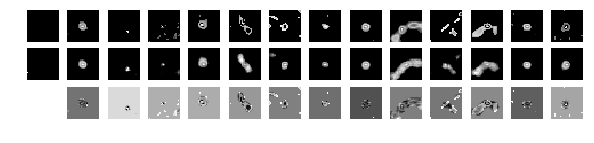

In [7]:
n_examples = 14
idx = np.random.permutation(len(X_te))
test_xs = X_te[idx[0:n_examples],:,:,:].astype('float32')

recon = cae.cae_test(img=test_xs)
print(recon.shape)

def gen_norm(img):
    return (img-img.min())/(img.max() - img.min())

fig, axs = plt.subplots(3, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    # raw
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (28, 28)), cmap='gray')
    axs[0][example_i].axis('off')
    # learned
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i, ...], (784,)),
            (28, 28)), cmap='gray')
    axs[1][example_i].axis('off')
    # residual
    norm_raw = gen_norm(np.reshape(test_xs[example_i, :], (28, 28)))
    norm_est = gen_norm(np.reshape(np.reshape(recon[example_i, ...], (784,)),(28, 28)))
    axs[2][example_i].imshow(norm_raw - norm_est, cmap='gray')
    axs[2][example_i].axis('off')

fig.show()
plt.draw()

In [12]:
code = np.random.uniform(low=0.0, high=6.0, size=(14,32)).astype('float32')
# img_de = cae.sess.run(cae.l_de, feed_dict={cae.l_in: None, cae.l_en: code, cae.droprate: 0.0})
img_de = cae.cae_decode(code=code)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


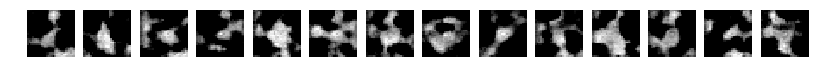

In [13]:
fig, axs = plt.subplots(1, n_examples,figsize=(14,1))
for example_i in range(n_examples):
    # learned
    axs[example_i].imshow(
        np.reshape(
            np.reshape(img_de[example_i, ...], (784,)),
            (28, 28)), cmap='gray')
    axs[example_i].axis('off')

fig.show()
plt.draw()

In [8]:
# encode
code = cae.cae_encode(img=test_xs)
print(code.shape)

(14, 32)


In [14]:
n_examples = 5000
idx = np.random.permutation(len(X_in))
test_xs = X_in[idx[0:n_examples],:,:,:].astype('float32')
code = cae.cae_encode(img=test_xs)

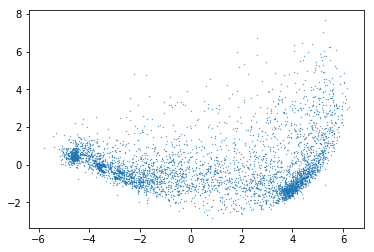

In [42]:
# PCA
# X_pca = PCA().fit_transform(code)
X_pca = utils.down_dimension(code=code, method='PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=0.1)
# plt.colorbar()
plt.show() 

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


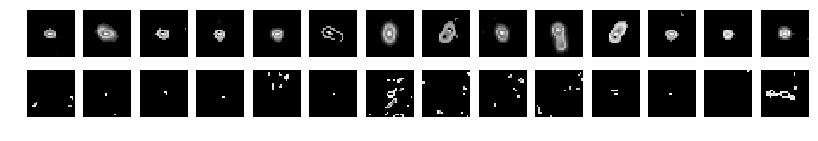

In [43]:
# kmeans to get labels of samples
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_pca[:,0:2])
labels = kmeans.labels_
n_examples = 14
X_diff = test_xs
idx_c1 = np.where(labels==0)[0]
idx_c2 = np.where(labels==1)[0]

imgs_c1 = X_diff[idx_c1[0:n_examples],:,:,:].astype('float32')
imgs_c2 = X_diff[idx_c2[0:n_examples],:,:,:].astype('float32')

fig, axs = plt.subplots(2, n_examples, figsize=(14, 2))
for example_i in range(n_examples):
    # raw
    axs[0][example_i].imshow(
        np.reshape(imgs_c1[example_i, ...], (28, 28)), cmap='gray')
    axs[0][example_i].axis('off')
    # learned
    axs[1][example_i].imshow(
        np.reshape(imgs_c2[example_i, ...], (28, 28)), cmap='gray')
    axs[1][example_i].axis('off')
    
fig.show()
plt.draw()

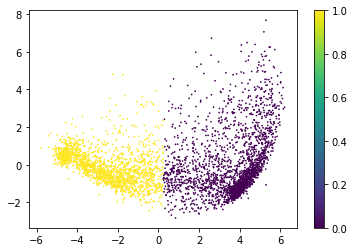

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=0.5)
plt.colorbar()
plt.show() 

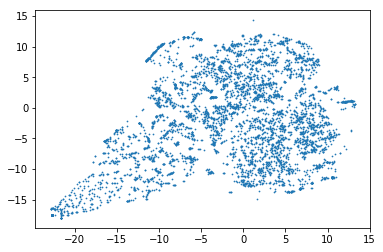

In [30]:
X_tsne = utils.down_dimension(code=code, method='tSNE', params={'n_components': 3, 'learning_rate': 100})
# X_tsne = TSNE(n_components=4,learning_rate=100).fit_transform(code)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],s=0.5)
# plt.colorbar()
plt.show() 

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


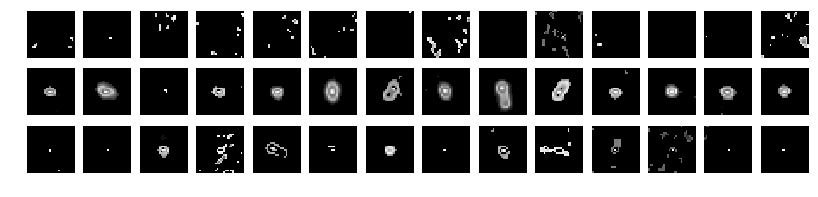

In [45]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_tsne[:,0:2])
labels = kmeans.labels_
n_examples = 14
X_diff = test_xs
idx_c1 = np.where(labels==0)[0]
idx_c2 = np.where(labels==1)[0]
idx_c3 = np.where(labels==2)[0]

imgs_c1 = X_diff[idx_c1[0:n_examples],:,:,:].astype('float32')
imgs_c2 = X_diff[idx_c2[0:n_examples],:,:,:].astype('float32')
imgs_c3 = X_diff[idx_c3[0:n_examples],:,:,:].astype('float32')

fig, axs = plt.subplots(3, n_examples, figsize=(14, 3))
for example_i in range(n_examples):
    # raw
    axs[0][example_i].imshow(
        np.reshape(imgs_c1[example_i, ...], (28, 28)), cmap='gray')
    axs[0][example_i].axis('off')
    # learned
    axs[1][example_i].imshow(
        np.reshape(imgs_c2[example_i, ...], (28, 28)), cmap='gray')
    axs[1][example_i].axis('off')
    # learned
    axs[2][example_i].imshow(
         np.reshape(imgs_c3[example_i, ...], (28, 28)), cmap='gray')
    axs[2][example_i].axis('off')
    
fig.show()
plt.draw()

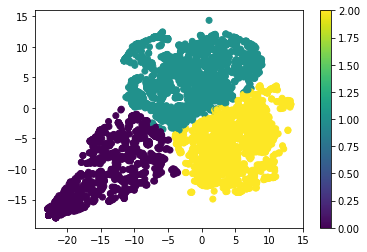

In [41]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.colorbar()
plt.show() 